<a href="https://colab.research.google.com/github/ED19841002/testrepo/blob/main/Drug_Discovery_Chemical_Space_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Install RDKit (Only needed in Google Colab)
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!mamba install -c conda-forge rdkit -y


Looking for: ['rdkit']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   1%
conda-forge/noarch     5%[+] 0.3s
conda-forge/linux-64   9%
conda-forge/noarch    33%[+] 0.4s
conda-forge/linux-64  20%
conda-forge/noarch    55%[+] 0.5s
conda-forge/linux-64  31%
conda-forge/noarch    78%[+] 0.6s
conda-forge/linux-64  36%
conda-forge/noarch   100%[+] 0.7s
conda-forge/linux-64  36%
conda-forge/noarch   100%conda-forge/noarch                                
[+] 0.8s
conda-forge/linux-64  40%[+] 0.9s
conda-forge/linux-64  58%[+] 1.0s
conda-forge/linux-64  76%[+] 1.1s
conda-forge/linux-64  94%[+] 1.2s
conda-forge/linux-64  94%[+] 1.3s
conda-forge/linux-64  94%[+] 1.4s
conda-forge/linux-64  94%conda-forge/linux-64                              

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [ ]:
import rdkit
print(rdkit.__version__)

2025.03.1


In [3]:
# CELL 1: Setup Environment (Run every time)

# ✅ Import necessary libraries

import os

import numpy as np

import pandas as pd

import zipfile

import gc

import h5py

import joblib

import torch

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm

from scipy.stats import skew

from scipy.sparse import csr_matrix, vstack

from joblib import parallel_backend

import xgboost as xgb

import lightgbm as lgb

import cupy as cp

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler

from rdkit import Chem

from rdkit.Chem import AllChem, DataStructs, rdFingerprintGenerator

import time

from google.colab import drive


# ✅ Check GPU availability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ Using device: {device}")


# ✅ Set up environment variables for performance optimization

NUM_THREADS = min(12, os.cpu_count())

os.environ["OMP_NUM_THREADS"] = str(NUM_THREADS)

os.environ["MKL_NUM_THREADS"] = str(NUM_THREADS)

os.environ["OPENBLAS_NUM_THREADS"] = str(NUM_THREADS)

os.environ["VECLIB_MAXIMUM_THREADS"] = str(NUM_THREADS)

os.environ["NUMEXPR_NUM_THREADS"] = str(NUM_THREADS)


print(f"✅ Using {NUM_THREADS} CPU threads for parallel processing.")


# ✅ Mount Google Drive

drive.mount('/content/drive')


# ✅ Set base directories

base_dir = "/content/drive/My Drive/Colab Notebooks/archive"

data_dir = os.path.join(base_dir, "raw_data")

processed_dir = os.path.join(base_dir, "processed_data")


# ✅ Create directories if they don't exist

os.makedirs(data_dir, exist_ok=True)

os.makedirs(processed_dir, exist_ok=True)

✅ Using device: cuda
✅ Using 12 CPU threads for parallel processing.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#CELL 2: Extract Data (Run every time)

# ✅ Define ZIP file path

zip_file = os.path.join(data_dir, "archive.zip")

extracted_dir = os.path.join(data_dir, "extracted")


# ✅ Extract ZIP file if not already extracted

if not os.path.exists(extracted_dir):

    if not os.path.exists(zip_file):

        raise FileNotFoundError(f"❌ ERROR: {zip_file} not found in Google Drive!")



    with zipfile.ZipFile(zip_file, "r") as zip_ref:

        zip_ref.extractall(extracted_dir)

    print("✅ archive.zip extracted successfully!")


# ✅ List extracted files

print(f"📂 Extracted Files: {os.listdir(extracted_dir)}")

📂 Extracted Files: ['Maragakis et al DUDE docking scores and vortex properties.csv', 'Maragakis et al test SMILES set.smi', 'Maragakis et al test SMILES with matched fingerprints without matched graph.csv', 'Maragakis et al training SMILES set 20 percent', 'training_smiles_2.smi', 'Maragakis et al training SMILES set 80 percent', 'training_smiles.smi', 'Maragakis et al validation SMILES 10k set.smi', 'Maragakis et al validation SMILES full set.smi']


In [5]:
#Cell 3: Load Data (Run every time)

# ✅ Define file path & load CSV

csv_path = os.path.join(extracted_dir, "Maragakis et al DUDE docking scores and vortex properties.csv")

df = pd.read_csv(csv_path)


# ✅ Display dataset info

print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637292 entries, 0 to 637291
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 637292 non-null  object 
 1   score              637292 non-null  float64
 2   SMILES             637292 non-null  object 
 3   target             637292 non-null  object 
 4   MW                 637292 non-null  float64
 5   MW_EXACT           637292 non-null  float64
 6   XLogP              637292 non-null  float64
 7   HBA                637292 non-null  int64  
 8   HBD                637292 non-null  int64  
 9   LIPINSKI_COUNT     637292 non-null  int64  
 10  RO3_COUNT          637292 non-null  int64  
 11  TPSA_NO            637292 non-null  float64
 12  TPSA_NOPS          637292 non-null  float64
 13  HAC                637292 non-null  int64  
 14  AtomCount          637292 non-null  int64  
 15  BondCount          637292 non-null  int64  
 16  FS

In [ ]:
# CELL 4: Efficient Fingerprint Generation & Save (Run only once, first time)


# ✅ Define file paths

fingerprint_file = os.path.join(processed_dir, "processed_fingerprints.parquet")


# ✅ Define Morgan Fingerprint Generator

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)


# ✅ Check if fingerprints are already saved

if os.path.exists(fingerprint_file):

    print(f"✅ Fingerprints already exist at {fingerprint_file}. Skipping generation.")

else:

    print("🔹 Generating fingerprints...")


    # ✅ Extract SMILES column

    smiles_list = df["SMILES"].dropna().unique().tolist()  # Use unique SMILES to avoid duplication


    # ✅ Initialize storage

    fingerprint_data = []

    mol_ids = []


    # ✅ Process SMILES

    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):

        mol = Chem.MolFromSmiles(smiles)

        if mol:

            fingerprint = morgan_gen.GetFingerprint(mol)

            fingerprint_bits = np.zeros(2048, dtype=np.uint8)


            for bit_id in fingerprint.GetOnBits():

                fingerprint_bits[bit_id] = 1


            fingerprint_data.append(fingerprint_bits)

            mol_ids.append(smiles)


    # ✅ Convert to DataFrame

    dense_fingerprint_df = pd.DataFrame(fingerprint_data)

    dense_fingerprint_df.insert(0, "SMILES", mol_ids)  # Add SMILES as first column


    # ✅ Save as Parquet

    dense_fingerprint_df.to_parquet(fingerprint_file, compression="gzip")

    print(f"✅ Fingerprints saved to {fingerprint_file}")


    # ✅ Free memory

    del fingerprint_data, mol_ids

    gc.collect()

✅ Fingerprints already exist at /content/drive/My Drive/Colab Notebooks/archive/processed_data/processed_fingerprints.parquet. Skipping generation.


In [6]:
# CELL 5: Load saved fingerprint (Run every time)

# ✅ Define file path

fingerprint_file = os.path.join(processed_dir, "processed_fingerprints.parquet")


# ✅ Load fingerprints from file

if os.path.exists(fingerprint_file):

    print(f"✅ Loading fingerprints from {fingerprint_file}...")

    dense_fingerprint_df = pd.read_parquet(fingerprint_file)

    print(f"✅ Loaded fingerprints shape: {dense_fingerprint_df.shape}")

else:

    raise FileNotFoundError(f"❌ ERROR: {fingerprint_file} not found! Run Cell 4 first.")

✅ Loading fingerprints from /content/drive/My Drive/Colab Notebooks/archive/processed_data/processed_fingerprints.parquet...
✅ Loaded fingerprints shape: (637292, 2049)


In [7]:
# CELL 6: Load & Process Fingerprints Efficiently in Batches (Run Every Time)



# ✅ Define file paths

parquet_output = os.path.join(processed_dir, "processed_fingerprints.parquet")


# ✅ Load processed fingerprints from Parquet

if os.path.exists(parquet_output):

    print(f"✅ Loading fingerprints from {parquet_output}...")

    dense_fingerprint_df = pd.read_parquet(parquet_output)

    print(f"✅ Loaded fingerprints shape: {dense_fingerprint_df.shape}")

else:

    raise FileNotFoundError(f"❌ ERROR: {parquet_output} not found! Run Cell 4 first.")


# Debugging

print(f"Before merging: {df.shape}")


# ✅ Drop duplicate SMILES in df (keep first occurrence)

df = df.drop_duplicates(subset=["SMILES"], keep="first")


# ✅ Merge with original dataset (Left Join)

df = df.merge(dense_fingerprint_df, on="SMILES", how="left")


# Debugging

print(f"Merged df shape: {df.shape}")


# ✅ Handle missing fingerprints

df.fillna(df.median(numeric_only=True), inplace=True)

df.fillna("Unknown", inplace=True)


# ✅ One-hot encode 'target' column

df = pd.get_dummies(df, columns=["target"], drop_first=True)


# ✅ Convert fingerprints & features to NumPy arrays

X_fingerprints = df.iloc[:, -2048:].values  # Select last 2048 columns (fingerprints)


num_cols = df.select_dtypes(include=["int64", "float64"]).drop(columns=["score"], errors="ignore")

X_numeric = StandardScaler().fit_transform(num_cols)


# ✅ Ensure shapes match before stacking

if X_fingerprints.shape[0] != X_numeric.shape[0]:

    print("⚠️ Shape mismatch detected! Filtering data to match fingerprints.")

    df = df[df["SMILES"].isin(dense_fingerprint_df["SMILES"])]

    X_numeric = StandardScaler().fit_transform(df.select_dtypes(include=["int64", "float64"]).drop(columns=["score"], errors="ignore"))


# ✅ Combine fingerprint & numerical features

X = np.hstack((X_fingerprints, X_numeric))

y = df["score"].values


# ✅ Free memory

del df, dense_fingerprint_df, X_fingerprints, X_numeric

gc.collect()


# Debugging

print(f"✅ Features Shape (X): {X.shape}")

print(f"✅ Target Shape (y): {y.shape}")

✅ Loading fingerprints from /content/drive/My Drive/Colab Notebooks/archive/processed_data/processed_fingerprints.parquet...
✅ Loaded fingerprints shape: (637292, 2049)
Before merging: (637292, 25)
Merged df shape: (637292, 2073)
✅ Features Shape (X): (637292, 2069)
✅ Target Shape (y): (637292,)


/usr/local/lib/python3.11/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


🔹 Outlier & Skewness Analysis:
                    Outliers   Skewness
LIPINSKI_COUNT        86431   2.170527
HalogenCount          55803   2.078670
HBD                   18508   0.700259
FSP3                  16009   0.537832
XLogP                 15754  -0.098422
SpiroCount            11233   7.496595
RotBondCount           9084   0.721876
TPSA_NOPS              5761   0.363693
TPSA_NO                5558   0.355225
PosCount               4892  11.397076
NegCount               3318  13.884230
HBA                     975   0.168141
MW                      234  -0.244614
MW_EXACT                234  -0.244241
AtomCount               162  -0.115636
SimpleRingCount          36   0.047825
AromaticRingCount        18   0.317439
HAC                       4  -0.185550
RO3_COUNT                 0  -0.586345
BondCount                 0  -0.117288
ComponentCount            0        NaN


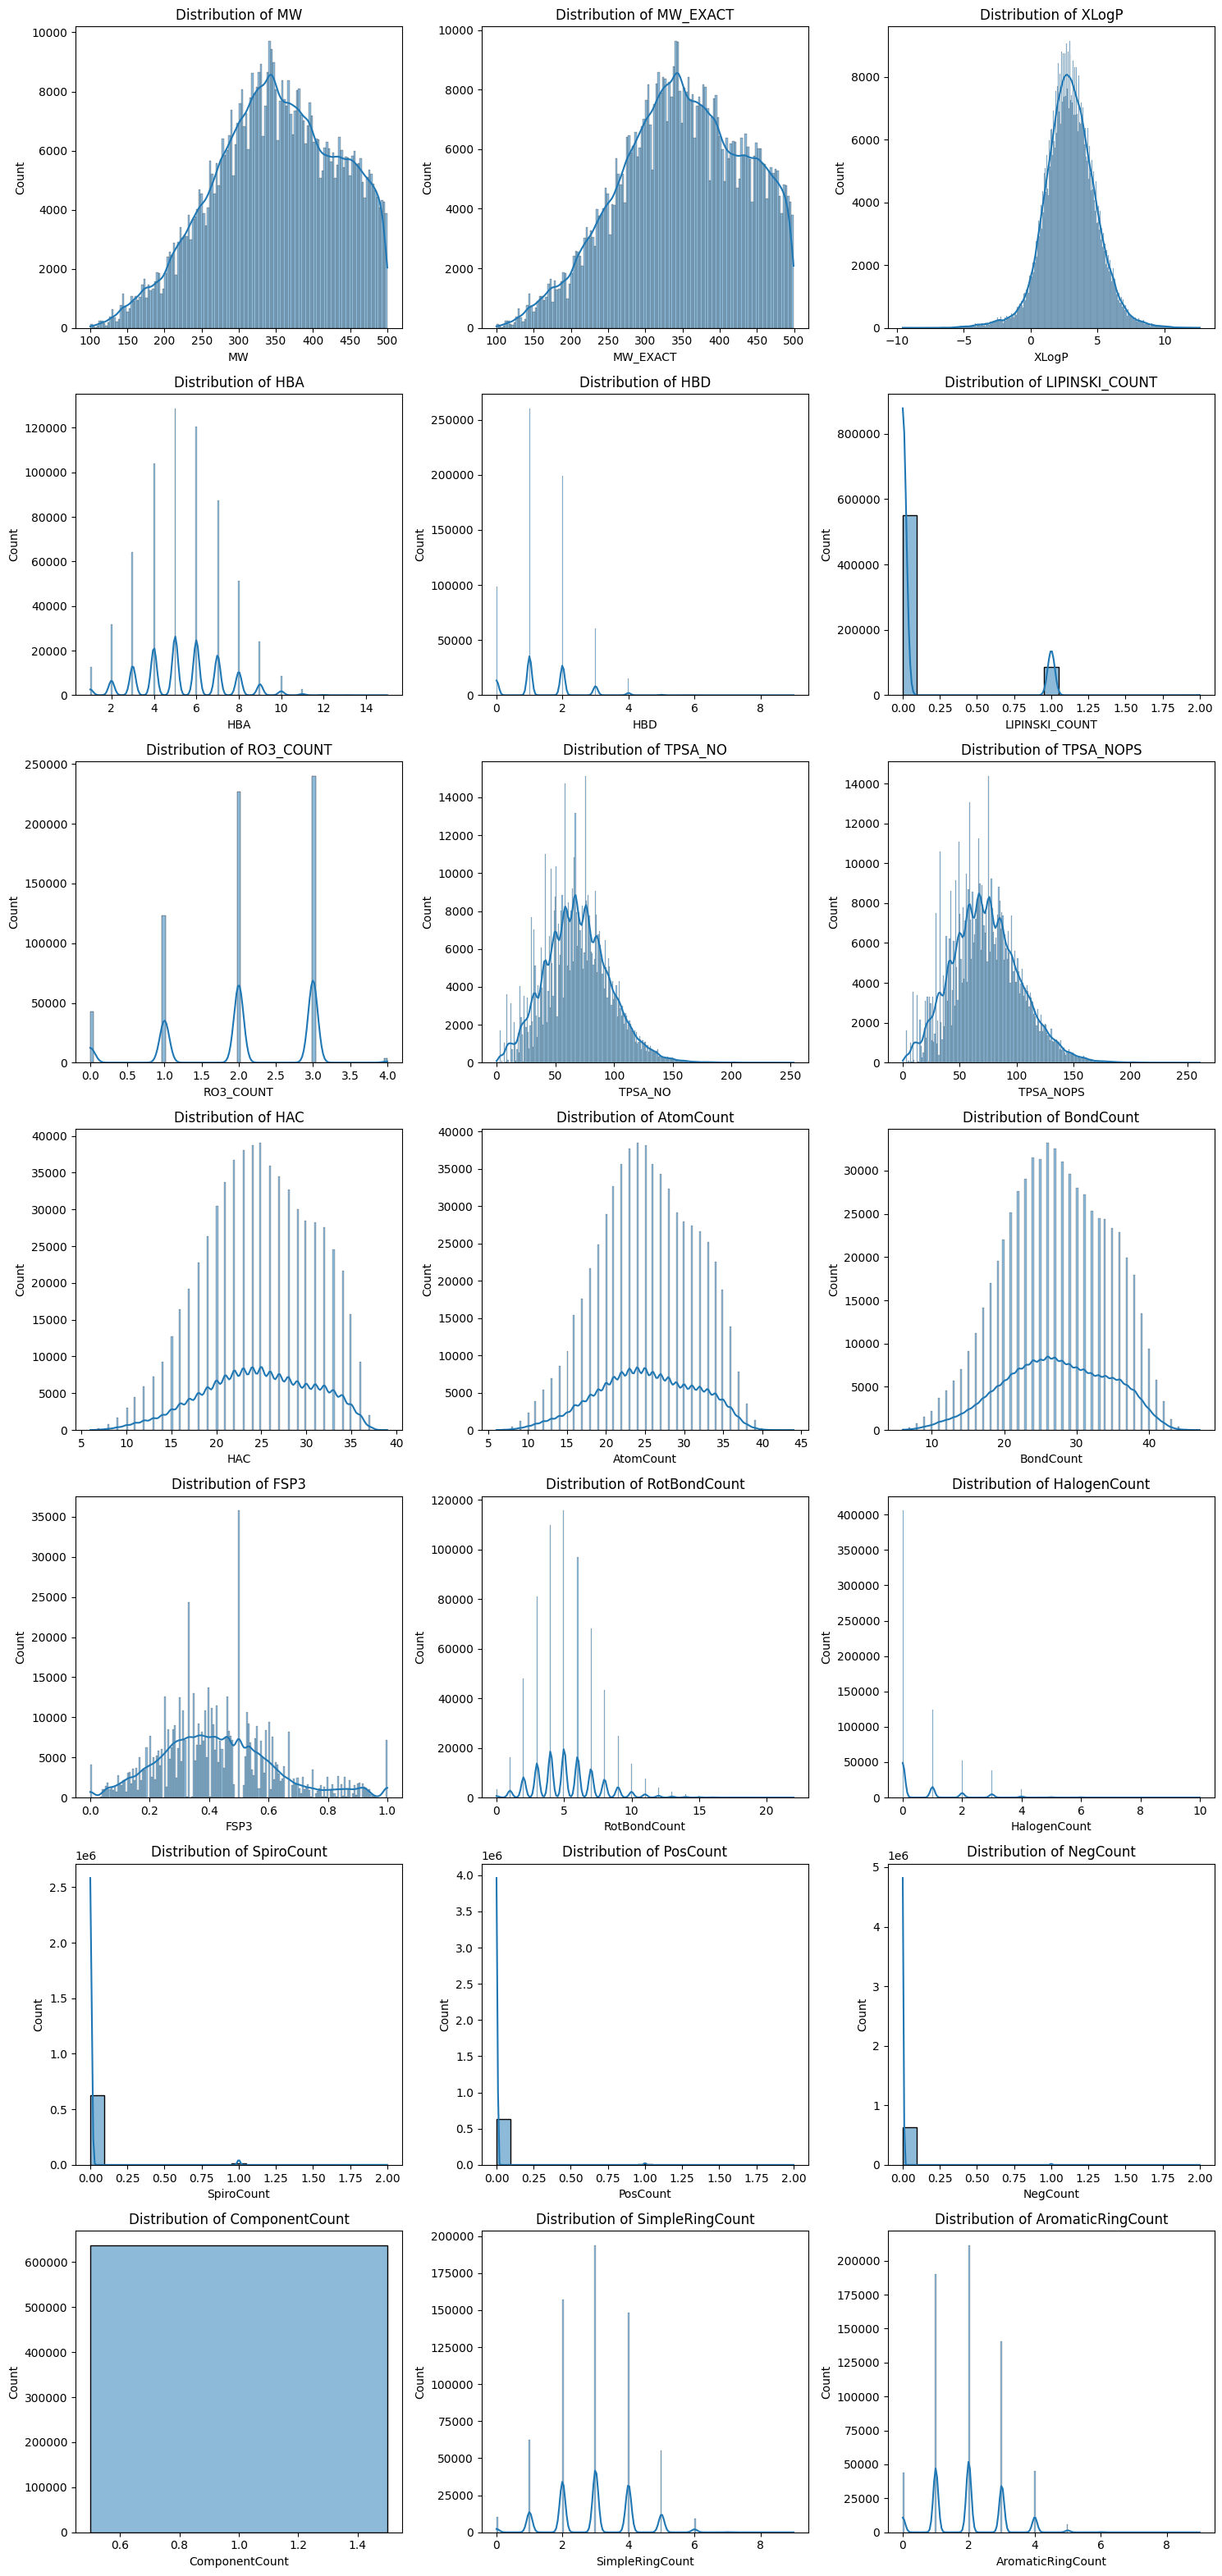

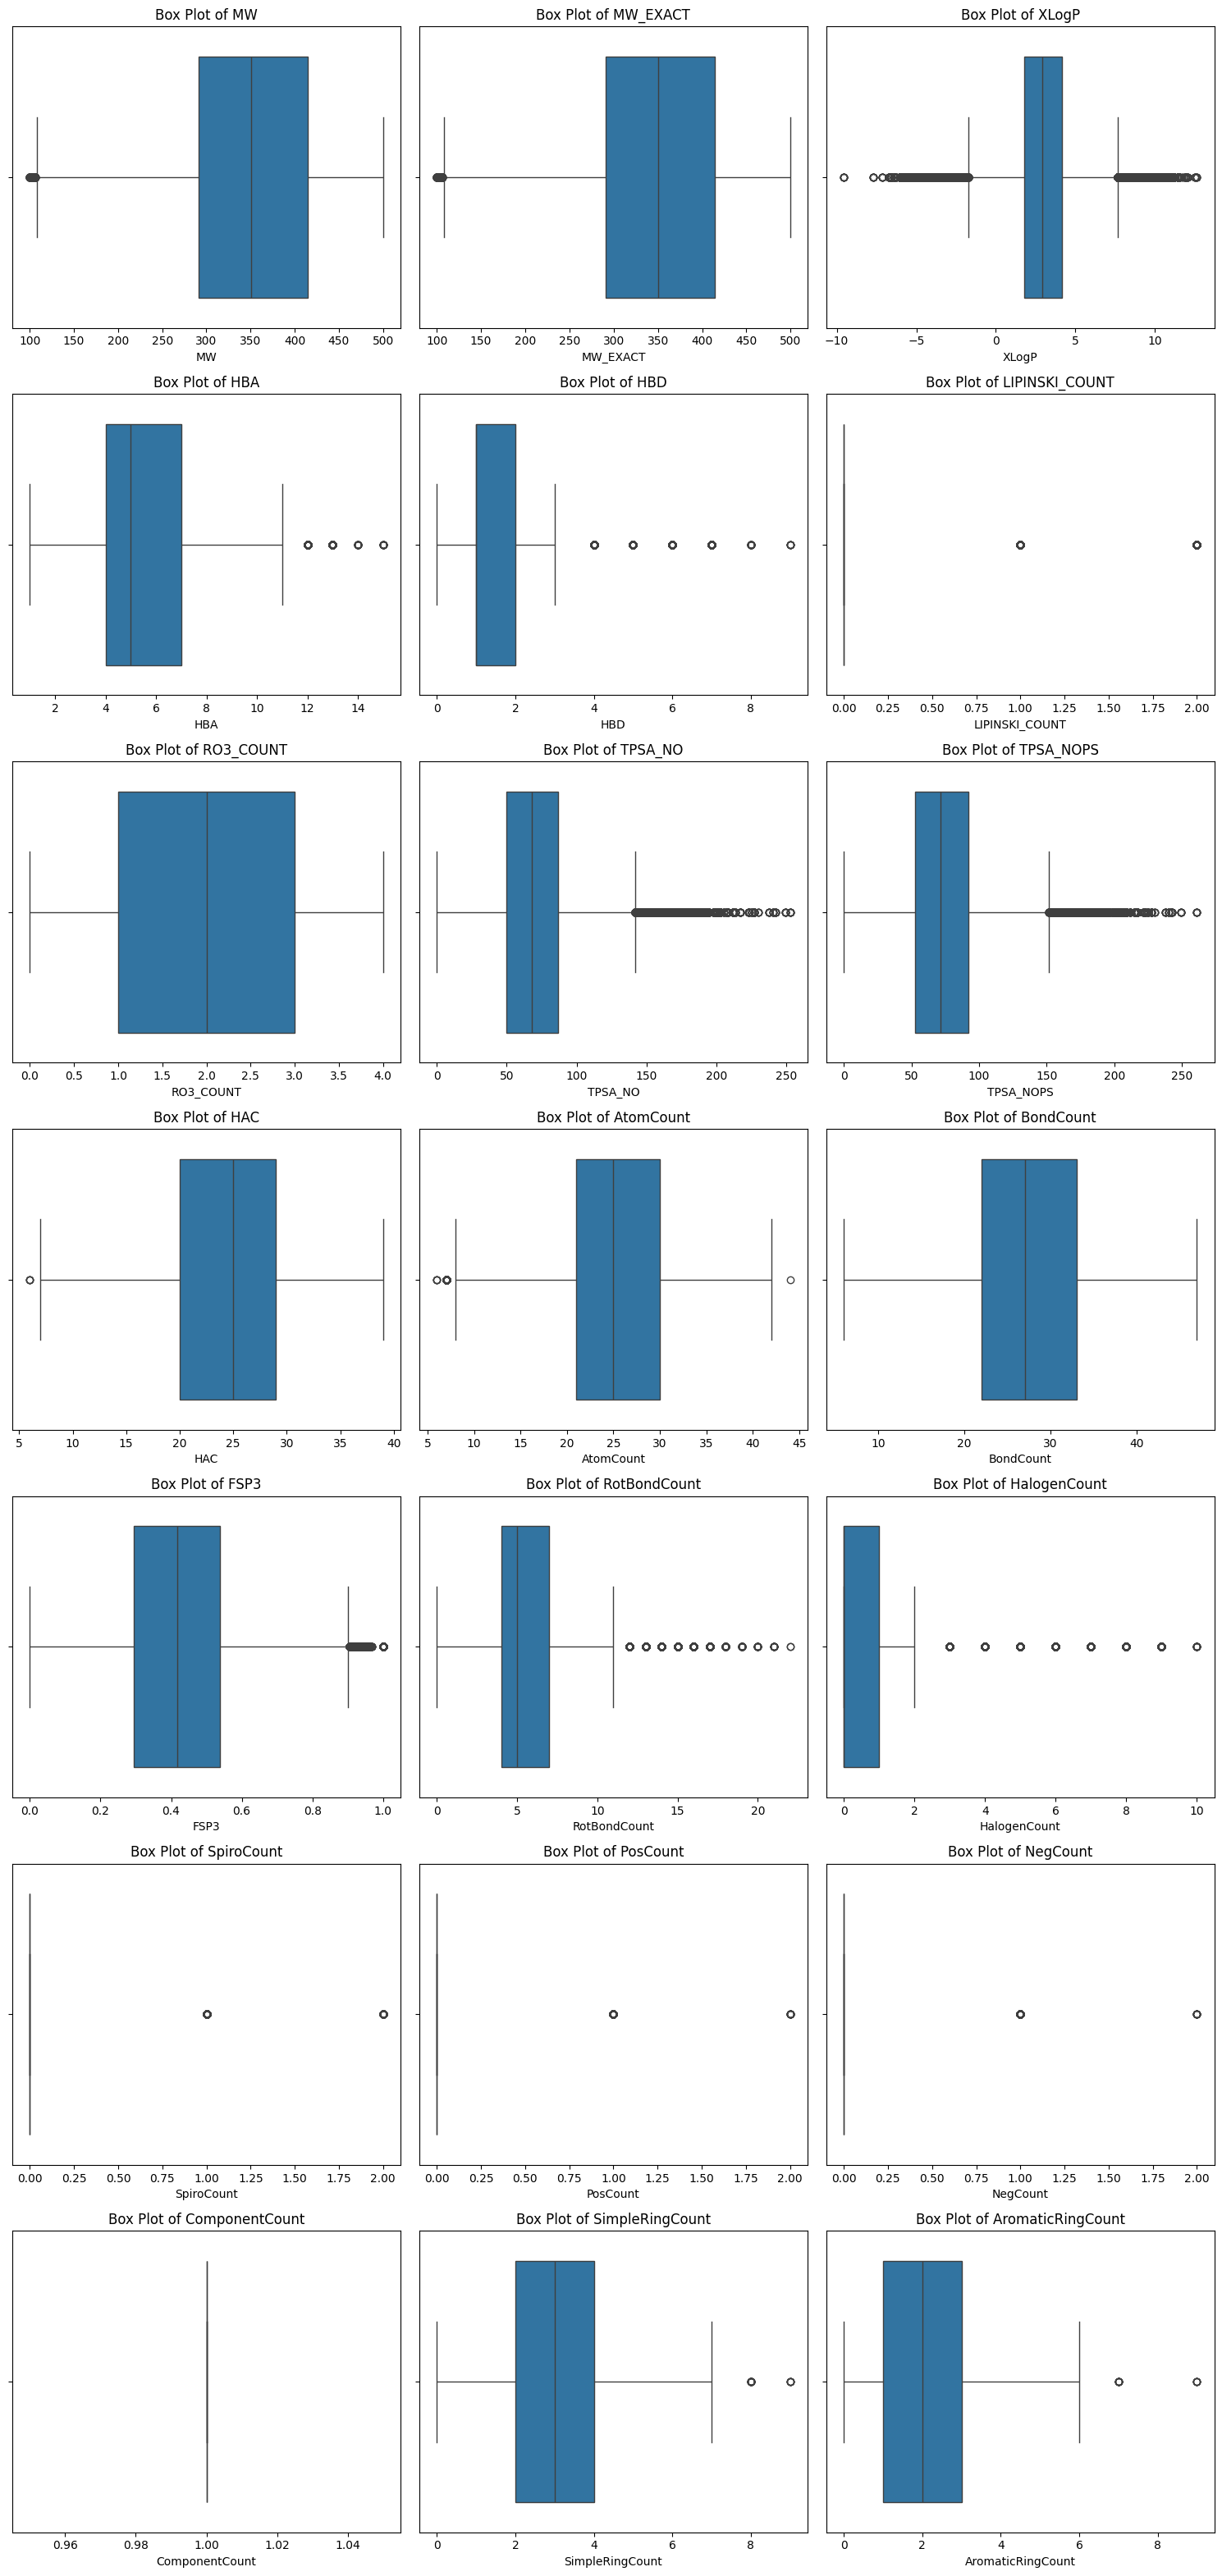

In [ ]:
# CELL 7A: Check for Outliers & Skewness (Only first time)



# ✅ Select numerical columns (excluding fingerprints and categorical columns)

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_cols.remove("score")  # Exclude target variable if applicable


# ✅ Detect outliers using the IQR method

outlier_counts = {}

for col in num_cols:

    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    outlier_counts[col] = outliers


# ✅ Compute skewness for each column

skewness = df[num_cols].apply(skew)


# ✅ Display results

outlier_df = pd.DataFrame({"Outliers": outlier_counts, "Skewness": skewness})

print("🔹 Outlier & Skewness Analysis:\n", outlier_df.sort_values(by="Outliers", ascending=False))


# ✅ Plot distributions & box plots

fig, axes = plt.subplots(nrows=len(num_cols)//3, ncols=3, figsize=(15, len(num_cols)*1.5))

axes = axes.flatten()


for i, col in enumerate(num_cols):

    sns.histplot(df[col], kde=True, ax=axes[i])

    axes[i].set_title(f"Distribution of {col}")


plt.tight_layout()

plt.show()


fig, axes = plt.subplots(nrows=len(num_cols)//3, ncols=3, figsize=(15, len(num_cols)*1.5))

axes = axes.flatten()


for i, col in enumerate(num_cols):

    sns.boxplot(x=df[col], ax=axes[i])

    axes[i].set_title(f"Box Plot of {col}")


plt.tight_layout()

plt.show()

In [ ]:


# CELL 7B: Handle Outliers & Skewness (Run Every Time). However, in the present dataset it's not needed




# ✅ Select numerical columns (excluding fingerprints and categorical columns)

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_cols.remove("score")  # Exclude target variable if applicable


# ✅ Winsorize extreme outliers (keep within 1st and 99th percentiles)

for col in num_cols:

    lower, upper = df[col].quantile([0.01, 0.99])

    df[col] = np.clip(df[col], lower, upper)


# ✅ Filter out nearly constant columns to avoid precision loss in skewness calculation

valid_cols = [col for col in num_cols if df[col].nunique() > 1]


# ✅ Compute skewness only for valid columns

if valid_cols:

    skewness = df[valid_cols].apply(skew, nan_policy="omit")  # Ignore NaN issues


    # ✅ Apply log transformation to highly skewed features (skewness > 1)

    for col in valid_cols:

        if abs(skewness[col]) > 1:

            df[col] = np.log1p(df[col])  # log1p to handle zero values safely


print("✅ Outliers handled and skewness reduced.")


# ✅ Free memory

del df, skewness, num_cols, valid_cols

gc.collect()


✅ Outliers handled and skewness reduced.


0

In [ ]:

# CELL 8A: Train XGBoost with GridSearchCV

# ✅ Define the XGBoost regressor

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", tree_method = "hist",
                         device = "cuda" ,random_state=42)

# ✅ Define the hyperparameter grid (medium range)

param_grid = {
    "n_estimators": [300],
    "learning_rate": [0.01, 0.2],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.2]
}

# ✅ Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Grid Search with Parallel Computing

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring="r2",
                           cv=4, n_jobs=-1, verbose=2)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")

# ✅ Get Best Model and its performance

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"✅ Best Model: {best_model}")
print(f"✅ Best Parameters: {best_params}")
print(f"✅ Best R^2 Score: {best_score:.4f}")

# ✅ Evaluate on Test Set

y_pred = best_model.predict(X_test)


r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# ✅ Free memory

del X_train, X_test, y_train, y_test, y_pred, best_model, best_params, best_score, grid_search, r2, rmse
gc.collect()

print("\n✅ Training completed successfully!")

Fitting 4 folds for each of 32 candidates, totalling 128 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


🕒 Time taken: 5929.90 seconds
✅ Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
✅ Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
✅ Best R^2 Score: 0.8147


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:56:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


R^2: 0.8733
RMSE: 13.1701

✅ Training completed successfully!


In [ ]:
# CELL 8B: Train XGBoost (The same as 8A but optimiuzed for GPU usage, with already optimized hyperparameters)




# ✅ Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert to NumPy, beacause it's a DataFrame

X_train = np.array(X_train, dtype=np.float32)

X_train = np.nan_to_num(X_train, nan=0.0)

X_test = np.array(X_test, dtype=np.float32)

X_test = np.nan_to_num(X_test, nan=0.0)

y_train = np.array(y_train, dtype=np.float32)

y_test = np.array(y_test, dtype=np.float32)

# ✅ Convert NumPy to CuPy arrays for GPU storage

X_train_gpu = cp.array(X_train)

X_test_gpu = cp.array(X_test)

y_train_gpu = cp.array(y_train)

y_test_gpu = cp.array(y_test)


# ✅ Define parameter grid

best_params = {

    "n_estimators": 300,

    "learning_rate": 0.4,

    "max_depth": 5,

    "subsample": 1.0,

    "colsample_bytree": 1.0,

    "gamma": 0.2

}


# ✅ Define XGBoost model

model_gpu = xgb.XGBRegressor(**best_params, objective="reg:squarederror",

                           tree_method="hist",

                           device="cuda",

                           random_state=42)



# ✅ Train Model
start_time = time.time()
model_gpu.fit(X_train_gpu, y_train_gpu)
end_time = time.time()

elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")


# ✅ Make Predictions (still in CuPy)

y_pred_gpu = model_gpu.predict(X_test_gpu)

# ✅ Convert CuPy arrays back to NumPy only for evaluation

y_test_np = cp.asnumpy(y_test_gpu)

y_pred_np = cp.asnumpy(y_pred_gpu)

# ✅ Evaluate Performance

r2 = r2_score(y_test_np, y_pred_np)

rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))


print(f"✅ Test R^2 Score: {r2:.4f}")

print(f"✅ Test RMSE Score: {rmse:.4f}")

# ✅ Calculate feature importance

# Get importance from GPU-trained model

feature_importance = model_gpu.get_booster().get_score(importance_type="gain")

# Convert to sorted list

sorted_fatures = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Display top 10 features

for feature, importance in sorted_fatures[:10]:

    print(f"{feature}: {importance:.4f}")

# ✅ Free memory

del X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu, y_pred_gpu, r2, rmse, model_gpu, y_test_np, y_pred_np, X_train, X_test, y_train, y_test, feature_importance, sorted_fatures

gc.collect()

print("\n✅ Training completed successfully!")

🕒 Time taken: 5.22 seconds
✅ Test R^2 Score: 0.9018
✅ Test RMSE Score: 11.5918
f5: 1826969.5000
f1099: 1701419.8750
f1744: 1380208.6250
f1284: 1351824.1250
f1064: 1218745.5000
f1030: 1205980.6250
f596: 1143055.5000
f962: 1096202.8750
f1642: 979689.1250
f1238: 975622.1250

✅ Training completed successfully!


In [8]:
# CELL 8C: LightGBoost on cpu and GridSearchCV

# ✅ Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert to NumPy and replace NaNs with 0 (LightGBM handles missing values, but safer)

X_train = np.nan_to_num(X_train)

X_test = np.nan_to_num(X_test)

# ✅ Define LightGBM model

lgb_model = lgb.LGBMRegressor(objective="regression" ,metric="rmse", verbose=-1)


# ✅ Define parameter grid

param_grid = {
    "boosting_type": ["gbdt"],

    "num_leaves": [32],

    "max_depth": [-1],

    "learning_rate": [0.4],

    "n_estimators": [300],

    "min_child_samples": [10],

    "subsample": [1.0],

    "colsample_bytree": [1.0],

    "reg_alpha": [0, 0.1],

    "reg_lambda": [0, 1.0],

}


# ✅ Run GridSearchCV (4-fold cross-validation)

with parallel_backend("loky", n_jobs=-1):

    grid_search = GridSearchCV(lgb_model, param_grid, cv=4, scoring="r2", verbose=1, n_jobs=-1, pre_dispatch="2*n_jobs")

    start_time = time.time()

    grid_search.fit(X_train, y_train)

    end_time = time.time()


elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")

# ✅ Print best parameters

print("Best Parameters:", grid_search.best_params_)
print("Best Score (RMSE):", -grid_search.best_score_)
print("Best Estimator:", grid_search.best_estimator_)


# ✅ Train LightGBM with best parameters

best_lgb_model = lgb.LGBMRegressor(**grid_search.best_params_, objective="regression", metric="rmse", verbose=-1)

best_lgb_model.fit(X_train, y_train)


# ✅ Make Predictions

y_pred_lgb = best_lgb_model.predict(X_test)


# ✅ Evaluate Performance

r2 = r2_score(y_test, y_pred_lgb)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))


print(f"✅ Test R² Score: {r2:.4f}")

print(f"✅ Test RMSE Score: {rmse:.4f}")

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🕒 Time taken: 836.62 seconds
Best Parameters: {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.4, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 32, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 1.0}
Best Score (RMSE): -0.8291883448253674
Best Estimator: LGBMRegressor(learning_rate=0.4, metric='rmse', min_child_samples=10,
              n_estimators=300, num_leaves=32, objective='regression',
              reg_alpha=0, reg_lambda=1.0, verbose=-1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Test R² Score: 0.9015
✅ Test RMSE Score: 11.6113
